# Benchmarking convolution

This notebook benchmarks several packages' implementations of direct and Fourier transform-based convolution using galaxy- and PSF-like images. It also compares against evaluation of a Gaussian mixture approximation with analytic convolution using MultiProFit.

In [1]:
import astropy.convolution as apconv
import galsim as gs
import inspect
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, signal
import timeit
from timeit import default_timer as timer

In [2]:
try:
    import cv2
    cv2_all = True
except Exception as error:
    print(f'Failed to import cv2: {error}')
    cv2_all = False
try:
    import multiprofit as mpf
    import multiprofit.fitutils as mpfFit
    import multiprofit.objects as mpfObj
    mpf_draw = True
except Exception as error:
    print(f'Failed to import multiprofit: {error}')
    mpf_draw = False
try:
    import pyprofit as profit
    profit_all = True
except Exception as error:
    print(f'Failed to import pyprofit: {error}')
    profit_all = False
try:
    import pyfftw
    pyfftw_all = True
except Exception as error:
    print(f'Failed to import pyfftw: {error}')
    pyfftw_all = False
try:
    from scarlet.observation import convolve
    from scarlet.interpolation import get_filter_coords, get_filter_bounds
    scarlet_direct = True
except Exception as error:
    scarlet_direct = False
    print(f'Failed to import scarlet direct: {error}')
try:
    from scarlet import fft
    scarlet_fft = True
except Exception as error:
    print(f'Failed to import scarlet fft: {error}')
    scarlet_fft = False

In [3]:
%matplotlib inline
#sns.set_style('dark')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.facecolor'] = 'w'

In [4]:
def imshow(imgs, show=True, title=None):
    fig, axes = plt.subplots(1, len(imgs))
    for axis, img in zip(axes, imgs):
        axis.imshow(img)
    if title:
        fig.suptitle(title, y=0.7)
    if show:
        plt.show(block=False)
    return fig, axes

Astropy convolve with minor efficiency boosts

- Add option to return the kernel fft for re-use
- Slightly optimize the 'fill' nan_treatment

In [5]:
from astropy import units as u

def _copy_input_if_needed(input, dtype=float, order='C', nan_treatment=None,
                          mask=None, fill_value=None):
    # strip quantity attributes
    if hasattr(input, 'unit'):
        input = input.value
    output = input
    # Copy input
    try:
        # Anything that's masked must be turned into NaNs for the interpolation.
        # This requires copying. A copy is also needed for nan_treatment == 'fill'
        # A copy prevents possible function side-effects of the input array.
        if nan_treatment == 'fill' or np.ma.is_masked(input) or mask is not None:
            if np.ma.is_masked(input):
                # ``np.ma.maskedarray.filled()`` returns a copy, however there
                # is no way to specify the return type or order etc. In addition
                # ``np.nan`` is a ``float`` and there is no conversion to an
                # ``int`` type. Therefore, a pre-fill copy is needed for non
                # ``float`` masked arrays. ``subok=True`` is needed to retain
                # ``np.ma.maskedarray.filled()``. ``copy=False`` allows the fill
                # to act as the copy if type and order are already correct.
                output = np.array(input, dtype=dtype, copy=False, order=order, subok=True)
                output = output.filled(fill_value)
            else:
                # Since we're making a copy, we might as well use `subok=False` to save,
                # what is probably, a negligible amount of memory.
                output = np.array(input, dtype=dtype, copy=True, order=order, subok=False)

            if mask is not None:
                # mask != 0 yields a bool mask for all ints/floats/bool
                output[mask != 0] = fill_value
        else:
            # The call below is synonymous with np.asanyarray(array, ftype=float, order='C')
            # The advantage of `subok=True` is that it won't copy when array is an ndarray subclass. If it
            # is and `subok=False` (default), then it will copy even if `copy=False`. This uses less memory
            # when ndarray subclasses are passed in.
            output = np.array(input, dtype=dtype, copy=False, order=order, subok=True)
    except (TypeError, ValueError) as e:
        raise TypeError('input should be a Numpy array or something '
                        'convertible into a float array', e)
    return output


def convolve_fft(array, kernel, boundary='fill', fill_value=0.,
                 nan_treatment='interpolate', normalize_kernel=True,
                 normalization_zero_tol=1e-8,
                 preserve_nan=False, mask=None, crop=True, return_fft=False,
                 return_kernfft=False, kernfft=None,
                 fft_pad=None, psf_pad=None, min_wt=0.0, allow_huge=False,
                 fftn=np.fft.fftn, ifftn=np.fft.ifftn,
                 complex_dtype=complex):
    # Check kernel is kernel instance
    if nan_treatment not in ('interpolate', 'fill'):
        raise ValueError("nan_treatment must be one of 'interpolate','fill'")

    # Convert array dtype to complex
    # and ensure that list inputs become arrays
    array = _copy_input_if_needed(array, dtype=complex, order='C',
                                  nan_treatment=nan_treatment, mask=mask,
                                  fill_value=np.nan)
    kernel = _copy_input_if_needed(kernel, dtype=complex, order='C',
                                   nan_treatment=None, mask=None,
                                   fill_value=0)

    # Check that the number of dimensions is compatible
    if array.ndim != kernel.ndim:
        raise ValueError("Image and kernel must have same number of "
                         "dimensions")

    arrayshape = array.shape
    kernshape = kernel.shape

    array_size_B = (np.product(arrayshape, dtype=np.int64) *
                    np.dtype(complex_dtype).itemsize)*u.byte
    if array_size_B > 1*u.GB and not allow_huge:
        raise ValueError("Size Error: Arrays will be {}.  Use "
                         "allow_huge=True to override this exception."
                         .format(human_file_size(array_size_B.to_value(u.byte))))

    # NaN and inf catching
    nanmaskarray = np.isnan(array) | np.isinf(array)
    if nan_treatment == 'fill':
        array[nanmaskarray] = fill_value
    else:
        array[nanmaskarray] = 0
    nanmaskkernel = np.isnan(kernel) | np.isinf(kernel)
    kernel[nanmaskkernel] = 0

    if normalize_kernel is True:
        if kernel.sum() < 1. / MAX_NORMALIZATION:
            raise Exception("The kernel can't be normalized, because its sum is "
                            "close to zero. The sum of the given kernel is < {}"
                            .format(1. / MAX_NORMALIZATION))
        kernel_scale = kernel.sum()
        normalized_kernel = kernel / kernel_scale
        kernel_scale = 1  # if we want to normalize it, leave it normed!
    elif normalize_kernel:
        # try this.  If a function is not passed, the code will just crash... I
        # think type checking would be better but PEPs say otherwise...
        kernel_scale = normalize_kernel(kernel)
        normalized_kernel = kernel / kernel_scale
    else:
        kernel_scale = kernel.sum()
        if np.abs(kernel_scale) < normalization_zero_tol:
            if nan_treatment == 'interpolate':
                raise ValueError('Cannot interpolate NaNs with an unnormalizable kernel')
            else:
                # the kernel's sum is near-zero, so it can't be scaled
                kernel_scale = 1
                normalized_kernel = kernel
        else:
            # the kernel is normalizable; we'll temporarily normalize it
            # now and undo the normalization later.
            normalized_kernel = kernel / kernel_scale

    if boundary is None:
        warnings.warn("The convolve_fft version of boundary=None is "
                      "equivalent to the convolve boundary='fill'.  There is "
                      "no FFT equivalent to convolve's "
                      "zero-if-kernel-leaves-boundary", AstropyUserWarning)
        if psf_pad is None:
            psf_pad = True
        if fft_pad is None:
            fft_pad = True
    elif boundary == 'fill':
        # create a boundary region at least as large as the kernel
        if psf_pad is False:
            warnings.warn("psf_pad was set to {}, which overrides the "
                          "boundary='fill' setting.".format(psf_pad),
                          AstropyUserWarning)
        else:
            psf_pad = True
        if fft_pad is None:
            # default is 'True' according to the docstring
            fft_pad = True
    elif boundary == 'wrap':
        if psf_pad:
            raise ValueError("With boundary='wrap', psf_pad cannot be enabled.")
        psf_pad = False
        if fft_pad:
            raise ValueError("With boundary='wrap', fft_pad cannot be enabled.")
        fft_pad = False
        fill_value = 0  # force zero; it should not be used
    elif boundary == 'extend':
        raise NotImplementedError("The 'extend' option is not implemented "
                                  "for fft-based convolution")

    # find ideal size (power of 2) for fft.
    # Can add shapes because they are tuples
    if fft_pad:  # default=True
        if psf_pad:  # default=False
            # add the dimensions and then take the max (bigger)
            fsize = 2 ** np.ceil(np.log2(
                np.max(np.array(arrayshape) + np.array(kernshape))))
        else:
            # add the shape lists (max of a list of length 4) (smaller)
            # also makes the shapes square
            fsize = 2 ** np.ceil(np.log2(np.max(arrayshape + kernshape)))
        newshape = np.full((array.ndim, ), fsize, dtype=int)
    else:
        if psf_pad:
            # just add the biggest dimensions
            newshape = np.array(arrayshape) + np.array(kernshape)
        else:
            newshape = np.array([np.max([imsh, kernsh])
                                 for imsh, kernsh in zip(arrayshape, kernshape)])

    # perform a second check after padding
    array_size_C = (np.product(newshape, dtype=np.int64) *
                    np.dtype(complex_dtype).itemsize)*u.byte
    if array_size_C > 1*u.GB and not allow_huge:
        raise ValueError("Size Error: Arrays will be {}.  Use "
                         "allow_huge=True to override this exception."
                         .format(human_file_size(array_size_C)))

    # separate each dimension by the padding size...  this is to determine the
    # appropriate slice size to get back to the input dimensions
    arrayslices = []
    kernslices = []
    for ii, (newdimsize, arraydimsize, kerndimsize) in enumerate(zip(newshape, arrayshape, kernshape)):
        center = newdimsize - (newdimsize + 1) // 2
        arrayslices += [slice(center - arraydimsize // 2,
                              center + (arraydimsize + 1) // 2)]
        kernslices += [slice(center - kerndimsize // 2,
                             center + (kerndimsize + 1) // 2)]
    arrayslices = tuple(arrayslices)
    kernslices = tuple(kernslices)

    if not np.all(newshape == arrayshape):
        if np.isfinite(fill_value):
            bigarray = np.ones(newshape, dtype=complex_dtype) * fill_value
        else:
            bigarray = np.zeros(newshape, dtype=complex_dtype)
        bigarray[arrayslices] = array
    else:
        bigarray = array

    if not np.all(newshape == kernshape):
        bigkernel = np.zeros(newshape, dtype=complex_dtype)
        bigkernel[kernslices] = normalized_kernel
    else:
        bigkernel = normalized_kernel

    arrayfft = fftn(bigarray)
    # need to shift the kernel so that, e.g., [0,0,1,0] -> [1,0,0,0] = unity
    if kernfft is None:
        kernfft = fftn(np.fft.ifftshift(bigkernel))
    else:
        if not kernfft.shape == arrayfft.shape:
            raise RuntimeError(f'kernfft.shape={kernfft.shape} != arrayfft.shape={arrayfft.shape}')
    if return_kernfft:
        return kernfft
       
    fftmult = arrayfft * kernfft
    
    interpolate_nan = (nan_treatment == 'interpolate')
    if interpolate_nan:
        if not np.isfinite(fill_value):
            bigimwt = np.zeros(newshape, dtype=complex_dtype)
        else:
            bigimwt = np.ones(newshape, dtype=complex_dtype)

        bigimwt[arrayslices] = 1.0 - nanmaskarray * interpolate_nan
        wtfft = fftn(bigimwt)

        # You can only get to this point if kernel_is_normalized
        wtfftmult = wtfft * kernfft
        wtsm = ifftn(wtfftmult)
        # need to re-zero weights outside of the image (if it is padded, we
        # still don't weight those regions)
        bigimwt[arrayslices] = wtsm.real[arrayslices]
        
    if np.isnan(fftmult).any():
        # this check should be unnecessary; call it an insanity check
        raise ValueError("Encountered NaNs in convolve.  This is disallowed.")

    fftmult *= kernel_scale

    if return_fft:
        return fftmult

    if interpolate_nan:
        with np.errstate(divide='ignore', invalid='ignore'):
            # divide by zeros are expected here; if the weight is zero, we want
            # the output to be nan or inf
            rifft = (ifftn(fftmult))
            if interpolate_nan:
                rifft /= bigimwt
        if interpolate_nan:
            if min_wt > 0.:
                rifft[bigimwt < min_wt] = np.nan
            else:
                # Set anything with no weight to zero (taking into account
                # slight offsets due to floating-point errors).
                rifft[bigimwt < 10 * np.finfo(bigimwt.dtype).eps] = 0.0
    else:
        rifft = ifftn(fftmult)

    if preserve_nan:
        rifft[arrayslices][nanmaskarray] = np.nan

    if crop:
        result = rifft[arrayslices].real
        return result
    else:
        return rifft.real

Using fftw in scarlet; diffs with scarlet/fft.py:

    3c3
    < #import autograd.numpy as np
    ---
    > import autograd.numpy as np
    169c178
    <         image = irfftw2(image_fft, s=fft_shape, axes=axes)
    ---
    >         image = np.fft.irfftn(image_fft, fft_shape, axes=axes)
    206c215
    <             self._fft[fft_key] = rfftw2(np.fft.ifftshift(image, axes), axes=axes)
    ---
    >             self._fft[fft_key] = np.fft.rfftn(np.fft.ifftshift(image, axes), axes=axes)
    288c299
    < def convolve_fftw(image1, image2, padding=3, axes=(-2, -1)):
    ---
    > def convolve(image1, image2, padding=3, axes=(-2, -1)):


In [6]:
# 

import operator

#import autograd.numpy as np
from scipy import fftpack

def _centered(arr, newshape):
    """Return the center newshape portion of the array.
    This function is used by `fft_convolve` to remove
    the zero padded region of the convolution.
    Note: If the array shape is odd and the target is even,
    the center of `arr` is shifted to the center-right
    pixel position.
    This is slightly different than the scipy implementation,
    which uses the center-left pixel for the array center.
    The reason for the difference is that we have
    adopted the convention of `np.fft.fftshift` in order
    to make sure that changing back and forth from
    fft standard order (0 frequency and position is
    in the bottom left) to 0 position in the center.
    """
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)

    if not np.all(newshape <= currshape):
        msg = (
            "arr must be larger than newshape in both dimensions, received {0}, and {1}"
        )
        raise ValueError(msg.format(arr.shape, newshape))

    startind = (currshape - newshape + 1) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]

    return arr[tuple(myslice)]


def _pad(arr, newshape, axes=None):
    """Pad an array to fit into newshape
    Pad `arr` with zeros to fit into newshape,
    which uses the `np.fft.fftshift` convention of moving
    the center pixel of `arr` (if `arr.shape` is odd) to
    the center-right pixel in an even shaped `newshape`.
    """
    if axes is None:
        newshape = np.asarray(newshape)
        currshape = np.array(arr.shape)
        dS = newshape - currshape
        startind = (dS + 1) // 2
        endind = dS - startind
        pad_width = list(zip(startind, endind))
    else:
        # only pad the axes that will be transformed
        pad_width = [(0, 0) for axis in arr.shape]
        try:
            len(axes)
        except TypeError:
            axes = [axes]
        for a, axis in enumerate(axes):
            dS = newshape[a] - arr.shape[axis]
            startind = (dS + 1) // 2
            endind = dS - startind
            pad_width[axis] = (startind, endind)
    return np.pad(arr, pad_width, mode="constant")


def _get_fft_shape(img1, img2, padding=3, axes=None, max=False):
    """Return the fast fft shapes for each spatial axis
    Calculate the fast fft shape for each dimension in
    axes.
    """
    shape1 = np.asarray(img1.shape)
    shape2 = np.asarray(img2.shape)
    # Make sure the shapes are the same size
    if len(shape1) != len(shape2):
        msg = (
            "img1 and img2 must have the same number of dimensions, but got {0} and {1}"
        )
        raise ValueError(msg.format(len(shape1), len(shape2)))
    # Set the combined shape based on the total dimensions
    if axes is None:
        if max:
            shape = np.max([shape1, shape2], axis=1)
        else:
            shape = shape1 + shape2
    else:
        shape = np.zeros(len(axes), dtype='int')
        try:
            len(axes)
        except TypeError:
            axes = [axes]
        for n, ax in enumerate(axes):
            shape[n] = shape1[ax] + shape2[ax]
            if max == True:
                shape[n] = np.max([shape1[ax], shape2[ax]])

    shape += padding
    # Use the next fastest shape in each dimension
    shape = [fftpack.helper.next_fast_len(s) for s in shape]
    # autograd.numpy.fft does not currently work
    # if the last dimension is odd
    while shape[-1] % 2 != 0:
        shape[-1] += 1
        shape[-1] = fftpack.helper.next_fast_len(shape[-1])

    return shape


class Fourier(object):
    """An array that stores its Fourier Transform
    The `Fourier` class is used for images that will make
    use of their Fourier Transform multiple times.
    In order to prevent numerical artifacts the same image
    convolved with different images might require different
    padding, so the FFT for each different shape is stored
    in a dictionary.
    """

    def __init__(self, image, image_fft=None):
        """Initialize the object
        Parameters
        ----------
        image: array
            The real space image.
        image_fft: dict
            A dictionary of {shape: fft_value} for which each different
            shape has a precalculated FFT.
        axes: int or tuple
            The dimension(s) of the array that will be transformed.
        """
        if image_fft is None:
            self._fft = {}
        else:
            self._fft = image_fft
        self._image = image

    @staticmethod
    def from_fft(image_fft, fft_shape, image_shape, axes=None):
        """Generate a new Fourier object from an FFT dictionary
        If the fft of an image has been generated but not its
        real space image (for example when creating a convolution kernel),
        this method can be called to create a new `Fourier` instance
        from the k-space representation.
        Parameters
        ----------
        image_fft: array
            The FFT of the image.
        fft_shape: tuple
            "Fast" shape of the image used to generate the FFT.
            This will be different than `image_fft.shape` if
            any of the dimensions are odd, since `np.fft.rfft`
            requires an even number of dimensions (for symmetry),
            so this tells `np.fft.irfft` how to go from
            complex k-space to real space.
        image_shape: tuple
            The shape of the image *before padding*.
            This will regenerate the image with the extra
            padding stripped.
        axes: int or tuple
            The dimension(s) of the array that will be transformed.
        Returns
        -------
        result: `Fourier`
            A `Fourier` object generated from the FFT.
        """
        if axes is None:
            axes = range(len(image_fft))
        all_axes = range(len(image_shape))
        image = irfftw2(image_fft, s=fft_shape, axes=axes)
        # Shift the center of the image from the bottom left to the center
        image = np.fft.fftshift(image, axes=axes)
        # Trim the image to remove the padding added
        # to reduce fft artifacts
        image = _centered(image, image_shape)
        key = (tuple(fft_shape), tuple(axes), tuple(all_axes))

        return Fourier(image, {key: image_fft})

    @property
    def image(self):
        """The real space image"""
        return self._image

    @property
    def shape(self):
        """The shape of the real space image"""
        return self.image.shape

    def fft(self, fft_shape, axes):
        """The FFT of an image for a given `fft_shape` along desired `axes`
        """
        try:
            iter(axes)
        except TypeError:
            axes = (axes,)
        all_axes = range(len(self.image.shape))
        fft_key = (tuple(fft_shape), tuple(axes), tuple(all_axes))

        # If this is the first time calling `fft` for this shape,
        # generate the FFT.
        if fft_key not in self._fft:
            if len(fft_shape) != len(axes):
                msg = "fft_shape self.axes must have the same number of dimensions, got {0}, {1}"
                raise ValueError(msg.format(fft_shape, axes))
            image = _pad(self.image, fft_shape, axes)
            self._fft[fft_key] = rfftw2(np.fft.ifftshift(image, axes), axes=axes)
        return self._fft[fft_key]

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        # Make the index a tuple
        if not hasattr(index, "__getitem__"):
            index = tuple([index])

        # Axes that are removed from the shape of the new object
        removed = np.array(
            [
                n
                for n, idx in enumerate(index)
                if not isinstance(idx, slice) and idx is not None
            ]
        )

        # Create views into the fft transformed values, appropriately adjusting
        # the shapes for the new axes

        fft_kernels = {
            (
                tuple(
                    [s for idx, s in enumerate(key[0]) if key[1][idx] not in removed]
                ),
                tuple(
                    [a for ida, a in enumerate(key[1]) if key[1][ida] not in removed]
                ),
                tuple(
                    [
                        aa
                        for idaa, aa in enumerate(key[2])
                        if key[2][idaa] not in removed
                    ]
                ),
            ): kernel[index]
            for key, kernel in self._fft.items()
        }
        return Fourier(self.image[index], fft_kernels)


def _kspace_operation(image1, image2, padding, op, shape, axes):
    """Combine two images in k-space using a given `operator`
    `image1` and `image2` are required to be `Fourier` objects and
    `op` should be an operator (either `operator.mul` for a convolution
    or `operator.truediv` for deconvolution). `shape` is the shape of the
    output image (`Fourier` instance).
    """
    if len(image1.shape) != len(image2.shape):
        msg = "Both images must have the same number of axes, got {0} and {1}"
        raise Exception(msg.format(len(image1.shape), len(image2.shape)))
    fft_shape = _get_fft_shape(image1.image, image2.image, padding, axes)
    convolved_fft = op(image1.fft(fft_shape, axes), image2.fft(fft_shape, axes))
    # why is shape not image1.shape? images are never padded
    convolved = Fourier.from_fft(convolved_fft, fft_shape, shape, axes)
    return convolved


def match_psfs(psf1, psf2, padding=3, axes=(-2, -1)):
    """Calculate the difference kernel between two psfs
    Parameters
    ----------
    psf1: `Fourier`
        `Fourier` object representing the psf and it's FFT.
    psf2: `Fourier`
        `Fourier` object representing the psf and it's FFT.
    padding: int
        Additional padding to use when generating the FFT
        to supress artifacts.
    axes: tuple or None
        Axes that contain the spatial information for the PSFs.
    """
    if psf1.shape[0] < psf2.shape[0]:
        shape = psf2.shape
    else:
        shape = psf1.shape
    return _kspace_operation(psf1, psf2, padding, operator.truediv, shape, axes=axes)


def convolve_fftw(image1, image2, padding=3, axes=(-2, -1)):
    """Convolve two images
    Parameters
    ----------
    image1: `Fourier`
        `Fourier` object represeting the image and it's FFT.
    image2: `Fourier`
        `Fourier` object represeting the image and it's FFT.
    padding: int
        Additional padding to use when generating the FFT
        to supress artifacts.
    """
    return _kspace_operation(
        image1, image2, padding, operator.mul, image1.shape, axes=axes
    )

PSF 41 x image 20
Sum PSF=1.000e+00 img=9.963e-01


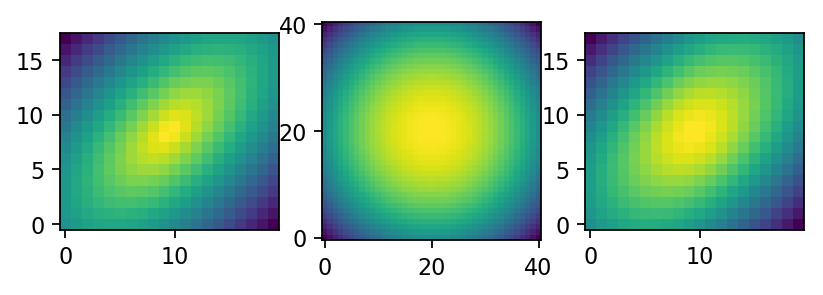

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.733e-03 for plot eval; timing 256x


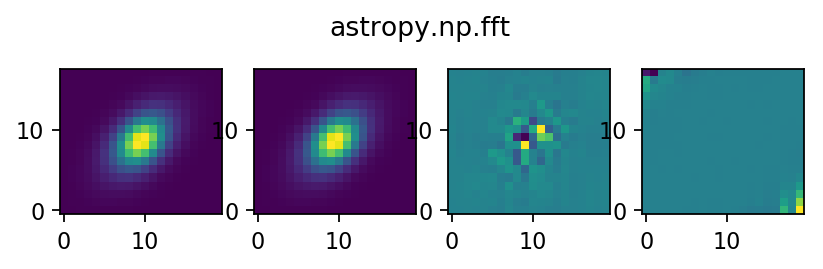

astropy.np.fft 1.153e-03s, abs. diff.: 5.987e-16; Ran 256x in 3.012e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.833e-03 for plot eval; timing 256x


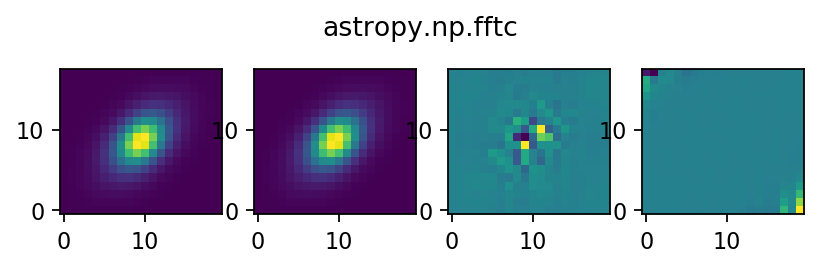

astropy.np.fftc 1.154e-03s, abs. diff.: 5.987e-16; Ran 256x in 3.010e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 7.224e-03s; Ran 1x in 7.343e-03s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 7.102e-04 for plot eval; timing 256x


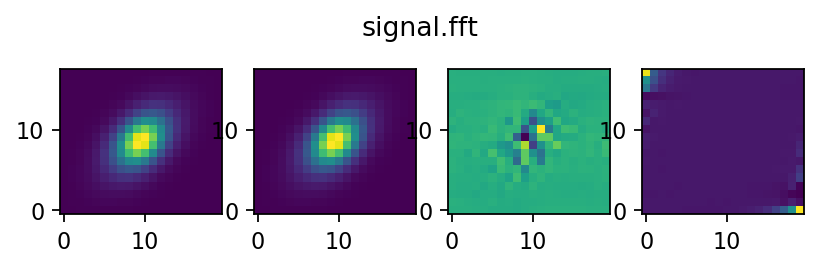

signal.fft 2.095e-04s, abs. diff.: 5.899e-16; Ran 256x in 6.164e-02s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 1.409e-02 for plot eval; timing 256x


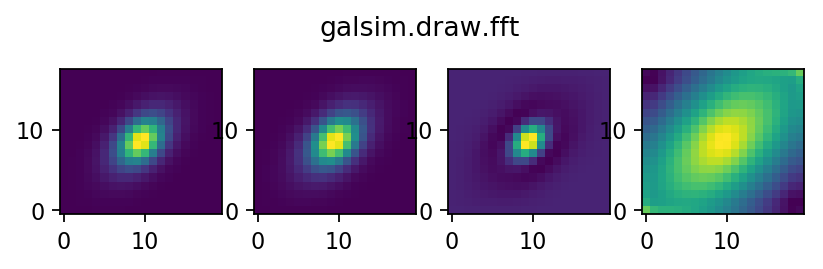

galsim.draw.fft 1.460e-03s, abs. diff.: 9.174e-02; Ran 256x in 3.819e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 7.089e-04 for plot eval; timing 256x


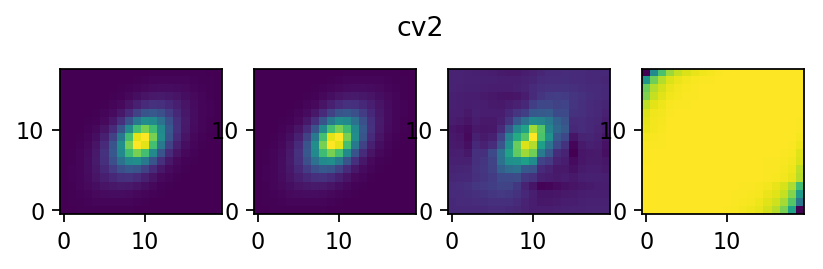

cv2 1.053e-04s, abs. diff.: 7.875e-15; Ran 256x in 2.820e-02s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 6.994e-03 for plot eval; timing 256x


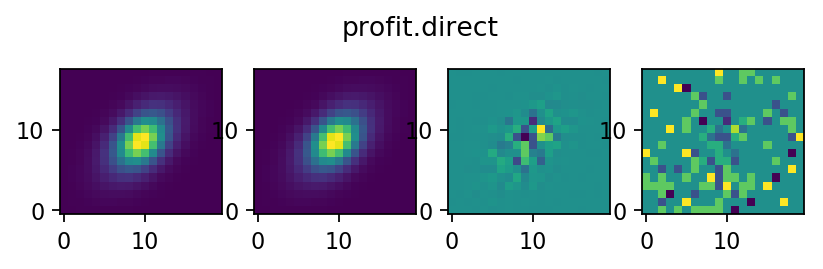

profit.direct 5.707e-04s, abs. diff.: 4.427e-16; Ran 256x in 1.503e-01s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 4.167e-03 for plot eval; timing 256x


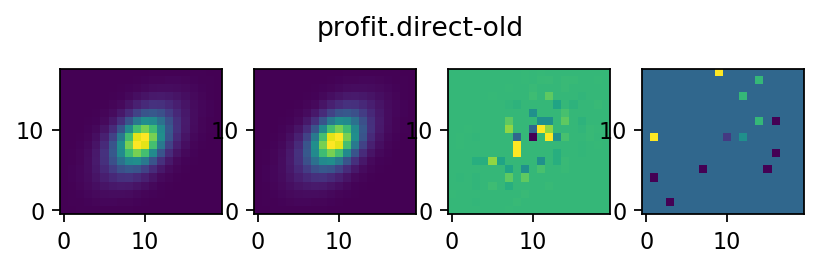

profit.direct-old 3.719e-03s, abs. diff.: 5.739e-17; Ran 256x in 1.096e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.781e-03 for plot eval; timing 256x


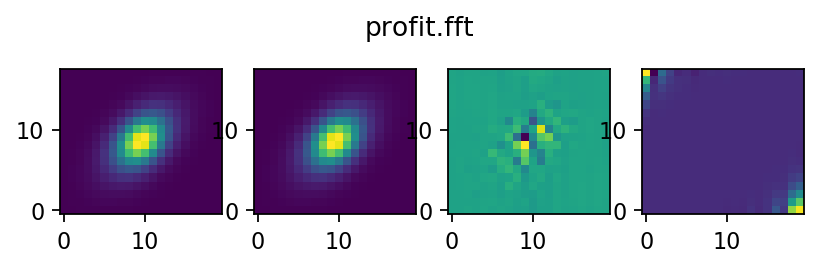

profit.fft 4.968e-04s, abs. diff.: 5.437e-16; Ran 256x in 1.311e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 5.095e-03 for plot eval; timing 256x


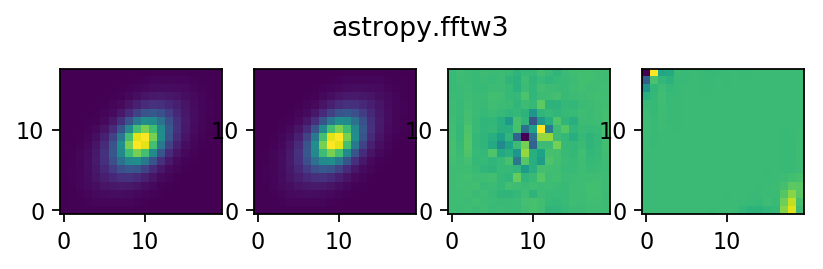

astropy.fftw3 1.257e-03s, abs. diff.: 6.854e-16; Ran 256x in 3.905e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.442e-03 for plot eval; timing 256x


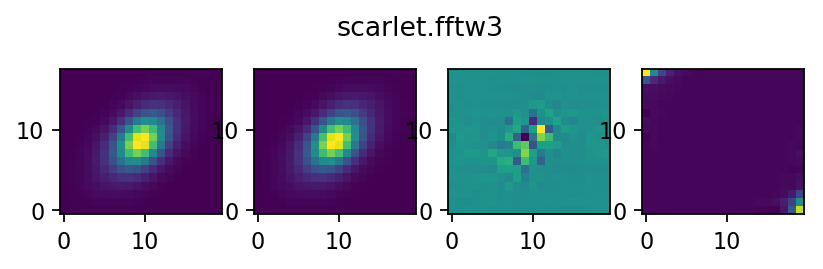

scarlet.fftw3 2.432e-04s, abs. diff.: 5.068e-16; Ran 256x in 6.343e-02s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 5.989e-04 for plot eval; timing 256x


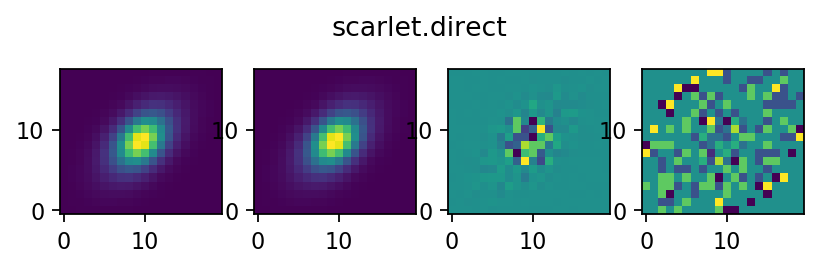

scarlet.direct 1.268e-04s, abs. diff.: 5.997e-16; Ran 256x in 3.380e-02s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 6.599e-04 for plot eval; timing 256x


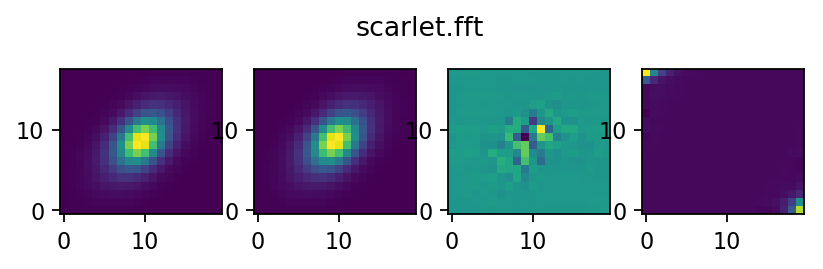

scarlet.fft 1.964e-04s, abs. diff.: 5.192e-16; Ran 256x in 5.246e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.205e-03 for plot eval; timing 256x


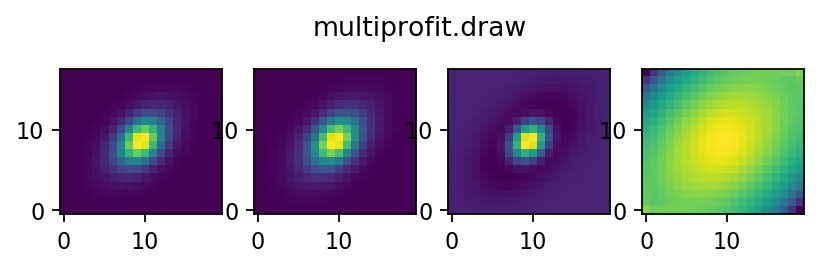

multiprofit.draw 7.485e-04s, abs. diff.: 9.771e-02; Ran 256x in 2.012e-01s
PSF 41 x image 21
Sum PSF=1.000e+00 img=9.964e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.087e-03 for plot eval; timing 256x
astropy.np.fft 6.242e-04s, abs. diff.: 5.619e-16; Ran 256x in 1.662e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.503e-03 for plot eval; timing 256x
astropy.np.fftc 6.341e-04s, abs. diff.: 5.619e-16; Ran 256x in 2.304e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 7.831e-03s; Ran 1x in 7.989e-03s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.575e-03 for plot eval;

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 3.725e-03 for plot eval; timing 256x
astropy.fftw3 7.053e-04s, abs. diff.: 6.283e-16; Ran 256x in 1.849e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.898e-03 for plot eval; timing 256x
scarlet.fftw3 2.932e-04s, abs. diff.: 6.417e-16; Ran 256x in 7.712e-02s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.094e-03 for plot eval; timing 256x
scarlet.direct 2.537e-04s, abs. diff.: 4.973e-16; Ran 256x in 6.688e-02s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.005e-03 for plot eval; timing 256x
scarlet.fft 2.141e-04s, abs. diff.: 6.616e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.826e-03 for plot eval; timing 256x
astropy.np.fft 1.298e-03s, abs. diff.: 5.836e-16; Ran 256x in 3.396e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.094e-03 for plot eval; timing 256x
astropy.np.fftc 1.111e-03s, abs. diff.: 5.836e-16; Ran 256x in 3.046e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.466e-02s; Ran 1x in 1.480e-02s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.579e-03 for plot eval; timing 256x
signal.fft 2.411e-04s, abs. diff.: 7.568e-16; Ran 256x in 6.406e-02s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 7.929e-04 for plot eval; timing 256x
cv2 1.433e-04s, abs. diff.: 2.319e-15; Ran 256x in 3.764e-02s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 9.087e-04 for plot eval; timing 256x
profit.direct 6.483e-04s, abs. diff.: 5.043e-16; Ran 256x in 1.689e-01s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 4.163e-03 for plot eval; timing 256x
profit.direct-old 3.812e-03s, abs. diff.: 4.772e-17; Ran 256x in 1.075e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 9.509e-04 for plot eval; timing 256x
profit.fft 5.125e-04s, abs. diff.: 6.916e-16; Ran 256x in 1.354e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.001e-03 for plot eval; timing 256x
scarlet.fftw3 3.609e-04s, abs. diff.: 7.192e-16; Ran 256x in 9.358e-02s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.341e-03 for plot eval; timing 256x
scarlet.direct 5.193e-04s, abs. diff.: 6.762e-16; Ran 256x in 1.339e-01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 9.152e-04 for plot eval; timing 256x
scarlet.fft 2.219e-04s, abs. diff.: 7.401e-16; Ran 256x in 1.033e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 2.552e-03 for plot eval; timing 256x
multiprofit.draw 9.095e-04s, abs. diff.: 1.088e-01; Ran 256x in 2.641e-01s
PSF 41 x image 33
Sum PSF=1.000e+00 img=9.969e-01
Running astropy.np.fft: {'astropy.np.fft': lambd

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 8.827e-04 for plot eval; timing 256x
profit.direct 7.134e-04s, abs. diff.: 6.065e-16; Ran 256x in 1.875e-01s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 4.128e-03 for plot eval; timing 256x
profit.direct-old 3.875e-03s, abs. diff.: 5.170e-17; Ran 256x in 1.016e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 8.525e-04 for plot eval; timing 256x
profit.fft 5.602e-04s, abs. diff.: 8.944e-16; Ran 256x in 1.517e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 5.627e-03 for plot eval; timing 256x
astropy.fftw3 9.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.117e-03 for plot eval; timing 256x
scarlet.direct 8.732e-04s, abs. diff.: 6.977e-16; Ran 256x in 2.363e-01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 9.112e-04 for plot eval; timing 256x
scarlet.fft 2.563e-04s, abs. diff.: 7.582e-16; Ran 256x in 6.696e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.562e-03 for plot eval; timing 256x
multiprofit.draw 9.422e-04s, abs. diff.: 1.118e-01; Ran 256x in 2.673e-01s
PSF 41 x image 40
Sum PSF=1.000e+00 img=9.971e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 3.132e-03 for plot eval; timing 256x
astropy.np.fft 1.465e-03s, abs. diff.: 6.065e-16; Ran 256x in 4.

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 3.487e-02s; Ran 1x in 3.499e-02s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 6.523e-04 for plot eval; timing 256x
signal.fft 2.893e-04s, abs. diff.: 8.842e-16; Ran 256x in 7.737e-02s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 1.811e-03 for plot eval; timing 256x
galsim.draw.fft 1.449e-03s, abs. diff.: 8.377e-02; Ran 256x in 3.791e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 3.906e-04 for plot eval; timing 256x
cv2 2.165e-04s, abs. diff.: 5.354e-15; Ran 256x in 5.688e-02s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 6.160e-04 for plot eval; timing 256x
scarlet.fft 2.565e-04s, abs. diff.: 8.077e-16; Ran 256x in 6.833e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.773e-03 for plot eval; timing 256x
multiprofit.draw 1.039e-03s, abs. diff.: 1.138e-01; Ran 256x in 2.716e-01s
PSF 41 x image 47
Sum PSF=1.000e+00 img=9.971e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.666e-03 for plot eval; timing 256x
astropy.np.fft 1.018e-03s, abs. diff.: 7.832e-16; Ran 256x in 2.680e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.868e-03 for plot eval; timing 256x
astropy.np.fftc 

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.026e-03 for plot eval; timing 256x
profit.fft 7.253e-04s, abs. diff.: 8.283e-16; Ran 256x in 1.912e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 5.337e-03 for plot eval; timing 256x
astropy.fftw3 1.186e-03s, abs. diff.: 7.427e-16; Ran 256x in 3.139e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.582e-03 for plot eval; timing 256x
scarlet.fftw3 3.671e-04s, abs. diff.: 7.115e-16; Ran 256x in 9.462e-02s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 2.120e-03 for plot eval; timing 256x
scarlet.direct 1.800e-03s, abs. diff.: 6.343e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.656e-03 for plot eval; timing 256x
multiprofit.draw 1.193e-03s, abs. diff.: 1.150e-01; Ran 256x in 3.242e-01s
PSF 41 x image 54
Sum PSF=1.000e+00 img=9.972e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.758e-03 for plot eval; timing 256x
astropy.np.fft 1.075e-03s, abs. diff.: 7.263e-16; Ran 256x in 2.873e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.966e-03 for plot eval; timing 256x
astropy.np.fftc 1.084e-03s, abs. diff.: 7.263e-16; Ran 256x in 2.874e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 6.199e-02s; Ran 1x in 6.213e-02

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 6.425e-03 for plot eval; timing 256x
astropy.fftw3 1.691e-03s, abs. diff.: 8.132e-16; Ran 256x in 4.372e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.801e-03 for plot eval; timing 256x
scarlet.fftw3 4.206e-04s, abs. diff.: 7.359e-16; Ran 256x in 1.091e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 2.995e-03 for plot eval; timing 256x
scarlet.direct 2.513e-03s, abs. diff.: 6.657e-16; Ran 256x in 6.542e-01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.125e-03 for plot eval; timing 256x
scarlet.fft 2.900e-04s, abs. diff.: 7.335e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.559e-03 for plot eval; timing 256x
astropy.np.fft 8.930e-04s, abs. diff.: 7.484e-16; Ran 256x in 2.310e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.645e-03 for plot eval; timing 256x
astropy.np.fftc 8.923e-04s, abs. diff.: 7.484e-16; Ran 256x in 2.305e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 7.693e-02s; Ran 1x in 7.704e-02s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 8.814e-04 for plot eval; timing 256x
signal.fft 3.926e-04s, abs. diff.: 8.356e-16; Ran 256x in 1.020e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 4.649e-04 for plot eval; timing 256x
cv2 3.311e-04s, abs. diff.: 1.308e-14; Ran 256x in 8.557e-02s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 1.905e-03 for plot eval; timing 256x
profit.direct 1.703e-03s, abs. diff.: 5.216e-16; Ran 256x in 4.431e-01s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 8.990e-03 for plot eval; timing 256x
profit.direct-old 8.904e-03s, abs. diff.: 5.526e-17; Ran 256x in 2.286e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.141e-03 for plot eval; timing 256x
profit.fft 8.978e-04s, abs. diff.: 7.967e-16; Ran 256x in 2.325e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 3.791e-03 for plot eval; timing 256x
scarlet.fftw3 4.132e-04s, abs. diff.: 8.621e-16; Ran 256x in 1.066e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 3.562e-03 for plot eval; timing 256x
scarlet.direct 3.298e-03s, abs. diff.: 6.732e-16; Ran 256x in 8.522e-01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 7.964e-04 for plot eval; timing 256x
scarlet.fft 3.223e-04s, abs. diff.: 8.276e-16; Ran 256x in 8.398e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.744e-03 for plot eval; timing 256x
multiprofit.draw 1.392e-03s, abs. diff.: 1.163e-01; Ran 256x in 3.619e-01s
PSF 41 x image 66
Sum PSF=1.000e+00 img=9.973e-01
Running astropy.np.fft: {'astropy.np.fft': lambd

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 2.413e-03 for plot eval; timing 256x
profit.direct 2.107e-03s, abs. diff.: 5.500e-16; Ran 256x in 5.527e-01s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 1.179e-02 for plot eval; timing 256x
profit.direct-old 1.108e-02s, abs. diff.: 4.980e-17; Ran 256x in 2.855e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.399e-03 for plot eval; timing 256x
profit.fft 1.058e-03s, abs. diff.: 8.363e-16; Ran 256x in 2.752e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.001e-02 for plot eval; timing 256x
astropy.fftw3 3.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 4.507e-03 for plot eval; timing 256x
scarlet.direct 4.143e-03s, abs. diff.: 6.587e-16; Ran 256x in 1.064e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 9.082e-04 for plot eval; timing 256x
scarlet.fft 3.371e-04s, abs. diff.: 8.088e-16; Ran 256x in 8.843e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.936e-03 for plot eval; timing 256x
multiprofit.draw 1.583e-03s, abs. diff.: 1.169e-01; Ran 256x in 4.123e-01s
PSF 41 x image 73
Sum PSF=1.000e+00 img=9.973e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.985e-03 for plot eval; timing 256x
astropy.np.fft 1.049e-03s, abs. diff.: 7.461e-16; Ran 256x in 2.

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.191e-01s; Ran 1x in 1.192e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.155e-03 for plot eval; timing 256x
signal.fft 4.649e-04s, abs. diff.: 9.113e-16; Ran 256x in 1.214e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 1.602e-03 for plot eval; timing 256x
galsim.draw.fft 1.290e-03s, abs. diff.: 8.063e-02; Ran 256x in 3.412e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 5.698e-04 for plot eval; timing 256x
cv2 4.153e-04s, abs. diff.: 2.105e-14; Ran 256x in 1.164e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 9.166e-04 for plot eval; timing 256x
scarlet.fft 3.473e-04s, abs. diff.: 8.521e-16; Ran 256x in 8.972e-02s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 2.050e-03 for plot eval; timing 256x
multiprofit.draw 1.729e-03s, abs. diff.: 1.172e-01; Ran 256x in 4.480e-01s
PSF 41 x image 80
Sum PSF=1.000e+00 img=9.973e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.754e-03 for plot eval; timing 256x
astropy.np.fft 1.223e-03s, abs. diff.: 8.337e-16; Ran 256x in 3.150e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.019e-03 for plot eval; timing 256x
astropy.np.fftc 

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.906e-03 for plot eval; timing 256x
profit.fft 1.481e-03s, abs. diff.: 8.197e-16; Ran 256x in 3.898e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 6.583e-03 for plot eval; timing 256x
astropy.fftw3 2.521e-03s, abs. diff.: 9.110e-16; Ran 256x in 6.496e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.585e-03 for plot eval; timing 256x
scarlet.fftw3 3.577e-04s, abs. diff.: 8.957e-16; Ran 256x in 9.357e-02s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 6.186e-03 for plot eval; timing 256x
scarlet.direct 5.772e-03s, abs. diff.: 6.607e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 2.556e-03 for plot eval; timing 256x
multiprofit.draw 1.979e-03s, abs. diff.: 1.175e-01; Ran 256x in 5.129e-01s
PSF 41 x image 87
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.882e-03 for plot eval; timing 256x
astropy.np.fft 1.095e-03s, abs. diff.: 7.465e-16; Ran 256x in 2.826e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.806e-03 for plot eval; timing 256x
astropy.np.fftc 1.101e-03s, abs. diff.: 7.465e-16; Ran 256x in 2.853e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.623e-01s; Ran 1x in 1.624e-01

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 5.199e-03 for plot eval; timing 256x
astropy.fftw3 1.381e-03s, abs. diff.: 7.968e-16; Ran 256x in 3.567e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.979e-03 for plot eval; timing 256x
scarlet.fftw3 4.303e-04s, abs. diff.: 8.494e-16; Ran 256x in 1.109e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 7.311e-03 for plot eval; timing 256x
scarlet.direct 6.846e-03s, abs. diff.: 6.797e-16; Ran 256x in 1.761e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.122e-03 for plot eval; timing 256x
scarlet.fft 4.003e-04s, abs. diff.: 8.982e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.699e-03 for plot eval; timing 256x
astropy.np.fft 1.373e-03s, abs. diff.: 8.392e-16; Ran 256x in 3.565e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.165e-03 for plot eval; timing 256x
astropy.np.fftc 1.370e-03s, abs. diff.: 8.392e-16; Ran 256x in 3.527e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.909e-01s; Ran 1x in 1.910e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.364e-03 for plot eval; timing 256x
signal.fft 5.560e-04s, abs. diff.: 1.024e-15; Ran 256x in 1.461e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 6.740e-04 for plot eval; timing 256x
cv2 6.006e-04s, abs. diff.: 2.111e-14; Ran 256x in 1.546e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 4.194e-03 for plot eval; timing 256x
profit.direct 4.168e-03s, abs. diff.: 5.454e-16; Ran 256x in 1.074e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 2.159e-02 for plot eval; timing 256x
profit.direct-old 2.137e-02s, abs. diff.: 6.001e-17; Ran 256x in 5.492e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 2.373e-03 for plot eval; timing 256x
profit.fft 1.847e-03s, abs. diff.: 8.000e-16; Ran 256x in 4.843e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 1.891e-03 for plot eval; timing 256x
scarlet.fftw3 5.048e-04s, abs. diff.: 9.487e-16; Ran 256x in 1.311e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 8.612e-03 for plot eval; timing 256x
scarlet.direct 8.013e-03s, abs. diff.: 6.215e-16; Ran 256x in 2.059e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 9.566e-04 for plot eval; timing 256x
scarlet.fft 4.095e-04s, abs. diff.: 9.062e-16; Ran 256x in 1.062e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 2.707e-03 for plot eval; timing 256x
multiprofit.draw 2.376e-03s, abs. diff.: 1.179e-01; Ran 256x in 6.140e-01s
PSF 41 x image 99
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambd

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 5.681e-03 for plot eval; timing 256x
profit.direct 5.208e-03s, abs. diff.: 5.570e-16; Ran 256x in 1.363e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 2.525e-02 for plot eval; timing 256x
profit.direct-old 2.487e-02s, abs. diff.: 5.537e-17; Ran 256x in 6.395e+00s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 5.968e-03 for plot eval; timing 256x
profit.fft 3.972e-03s, abs. diff.: 2.106e-15; Ran 256x in 1.024e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 7.626e-03 for plot eval; timing 256x
astropy.fftw3 3.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.017e-02 for plot eval; timing 256x
scarlet.direct 9.333e-03s, abs. diff.: 6.120e-16; Ran 256x in 2.451e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.159e-03 for plot eval; timing 256x
scarlet.fft 4.527e-04s, abs. diff.: 9.024e-16; Ran 256x in 1.193e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 3.061e-03 for plot eval; timing 256x
multiprofit.draw 2.757e-03s, abs. diff.: 1.180e-01; Ran 256x in 7.331e-01s
PSF 41 x image 106
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 3.511e-03 for plot eval; timing 256x
astropy.np.fft 1.711e-03s, abs. diff.: 8.493e-16; Ran 256x in 4

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 2.542e-01s; Ran 1x in 2.543e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.569e-03 for plot eval; timing 256x
signal.fft 6.690e-04s, abs. diff.: 1.046e-15; Ran 256x in 1.734e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 2.697e-03 for plot eval; timing 256x
galsim.draw.fft 1.291e-03s, abs. diff.: 3.727e-01; Ran 256x in 3.336e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 9.930e-04 for plot eval; timing 256x
cv2 7.310e-04s, abs. diff.: 1.774e-14; Ran 256x in 1.888e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.117e-03 for plot eval; timing 256x
scarlet.fft 4.750e-04s, abs. diff.: 9.517e-16; Ran 256x in 1.233e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 3.473e-03 for plot eval; timing 256x
multiprofit.draw 2.961e-03s, abs. diff.: 1.182e-01; Ran 256x in 7.665e-01s
PSF 41 x image 113
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.579e-03 for plot eval; timing 256x
astropy.np.fft 1.729e-03s, abs. diff.: 9.260e-16; Ran 256x in 4.451e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 2.485e-03 for plot eval; timing 256x
astropy.np.fftc

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 4.554e-03 for plot eval; timing 256x
profit.fft 2.803e-03s, abs. diff.: 9.194e-16; Ran 256x in 7.234e-01s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 7.937e-03 for plot eval; timing 256x
astropy.fftw3 3.120e-03s, abs. diff.: 1.010e-15; Ran 256x in 8.054e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.843e-03 for plot eval; timing 256x
scarlet.fftw3 6.200e-04s, abs. diff.: 8.903e-16; Ran 256x in 1.607e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.242e-02 for plot eval; timing 256x
scarlet.direct 1.172e-02s, abs. diff.: 7.142e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 5.143e-03 for plot eval; timing 256x
multiprofit.draw 3.338e-03s, abs. diff.: 1.183e-01; Ran 256x in 8.666e-01s
PSF 41 x image 120
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 4.892e-03 for plot eval; timing 256x
astropy.np.fft 2.787e-03s, abs. diff.: 8.428e-16; Ran 256x in 7.171e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 3.698e-03 for plot eval; timing 256x
astropy.np.fftc 2.791e-03s, abs. diff.: 8.428e-16; Ran 256x in 7.229e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 3.212e-01s; Ran 1x in 3.213e-0

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.272e-02 for plot eval; timing 256x
astropy.fftw3 4.037e-03s, abs. diff.: 1.043e-15; Ran 256x in 1.038e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.508e-03 for plot eval; timing 256x
scarlet.fftw3 5.845e-04s, abs. diff.: 8.939e-16; Ran 256x in 1.510e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.451e-02 for plot eval; timing 256x
scarlet.direct 1.477e-02s, abs. diff.: 6.608e-16; Ran 256x in 3.793e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.217e-03 for plot eval; timing 256x
scarlet.fft 5.776e-04s, abs. diff.: 8.968e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 5.459e-03 for plot eval; timing 256x
astropy.np.fft 3.735e-03s, abs. diff.: 9.680e-16; Ran 256x in 1.029e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 4.531e-03 for plot eval; timing 256x
astropy.np.fftc 3.745e-03s, abs. diff.: 9.680e-16; Ran 256x in 9.639e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 3.579e-01s; Ran 1x in 3.580e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.717e-03 for plot eval; timing 256x
signal.fft 9.221e-04s, abs. diff.: 9.724e-16; Ran 256x in 2.399e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 1.251e-03 for plot eval; timing 256x
cv2 1.006e-03s, abs. diff.: 2.573e-14; Ran 256x in 2.715e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 8.488e-03 for plot eval; timing 256x
profit.direct 8.173e-03s, abs. diff.: 5.294e-16; Ran 256x in 2.108e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 3.986e-02 for plot eval; timing 256x
profit.direct-old 3.955e-02s, abs. diff.: 5.330e-17; Ran 256x in 1.021e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 6.920e-03 for plot eval; timing 256x
profit.fft 4.888e-03s, abs. diff.: 7.257e-16; Ran 256x in 1.260e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.048e-03 for plot eval; timing 256x
scarlet.fftw3 5.671e-04s, abs. diff.: 9.328e-16; Ran 256x in 1.458e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.567e-02 for plot eval; timing 256x
scarlet.direct 1.507e-02s, abs. diff.: 6.693e-16; Ran 256x in 3.895e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.104e-03 for plot eval; timing 256x
scarlet.fft 5.550e-04s, abs. diff.: 9.228e-16; Ran 256x in 1.442e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 4.337e-03 for plot eval; timing 256x
multiprofit.draw 3.741e-03s, abs. diff.: 1.184e-01; Ran 256x in 9.657e-01s
PSF 41 x image 132
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lamb

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 8.646e-03 for plot eval; timing 256x
profit.direct 8.452e-03s, abs. diff.: 5.118e-16; Ran 256x in 2.201e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 4.390e-02 for plot eval; timing 256x
profit.direct-old 4.384e-02s, abs. diff.: 5.353e-17; Ran 256x in 1.129e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 6.369e-03 for plot eval; timing 256x
profit.fft 4.317e-03s, abs. diff.: 8.562e-16; Ran 256x in 1.113e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 7.116e-03 for plot eval; timing 256x
astropy.fftw3 3.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 1.944e-02 for plot eval; timing 256x
scarlet.direct 1.718e-02s, abs. diff.: 6.814e-16; Ran 256x in 4.426e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.164e-03 for plot eval; timing 256x
scarlet.fft 5.677e-04s, abs. diff.: 8.853e-16; Ran 256x in 1.467e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 5.123e-03 for plot eval; timing 256x
multiprofit.draw 4.111e-03s, abs. diff.: 1.185e-01; Ran 256x in 1.072e+00s
PSF 41 x image 139
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 5.890e-03 for plot eval; timing 256x
astropy.np.fft 4.429e-03s, abs. diff.: 1.034e-15; Ran 256x in 1

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 4.444e-01s; Ran 1x in 4.445e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.731e-03 for plot eval; timing 256x
signal.fft 9.140e-04s, abs. diff.: 1.143e-15; Ran 256x in 2.375e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 2.907e-03 for plot eval; timing 256x
galsim.draw.fft 2.099e-03s, abs. diff.: 6.447e-01; Ran 256x in 5.422e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 1.303e-03 for plot eval; timing 256x
cv2 1.044e-03s, abs. diff.: 2.757e-14; Ran 256x in 2.704e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.085e-03 for plot eval; timing 256x
scarlet.fft 6.156e-04s, abs. diff.: 8.891e-16; Ran 256x in 1.588e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 5.049e-03 for plot eval; timing 256x
multiprofit.draw 4.570e-03s, abs. diff.: 1.186e-01; Ran 256x in 1.182e+00s
PSF 41 x image 146
Sum PSF=1.000e+00 img=9.974e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 3.803e-03 for plot eval; timing 256x
astropy.np.fft 3.017e-03s, abs. diff.: 8.949e-16; Ran 256x in 7.880e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 3.629e-03 for plot eval; timing 256x
astropy.np.fftc

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 5.490e-03 for plot eval; timing 256x
profit.fft 4.216e-03s, abs. diff.: 9.072e-16; Ran 256x in 1.093e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 9.806e-03 for plot eval; timing 256x
astropy.fftw3 4.749e-03s, abs. diff.: 1.074e-15; Ran 256x in 1.220e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 4.271e-03 for plot eval; timing 256x
scarlet.fftw3 6.777e-04s, abs. diff.: 9.830e-16; Ran 256x in 1.754e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 2.251e-02 for plot eval; timing 256x
scarlet.direct 2.385e-02s, abs. diff.: 6.902e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 5.948e-03 for plot eval; timing 256x
multiprofit.draw 4.856e-03s, abs. diff.: 1.186e-01; Ran 256x in 1.253e+00s
PSF 41 x image 153
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 6.691e-03 for plot eval; timing 256x
astropy.np.fft 5.334e-03s, abs. diff.: 9.033e-16; Ran 256x in 1.371e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 5.967e-03 for plot eval; timing 256x
astropy.np.fftc 5.330e-03s, abs. diff.: 9.033e-16; Ran 256x in 1.368e+00s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 5.205e-01s; Ran 1x in 5.206e-0

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 7.005e-03 for plot eval; timing 256x
astropy.fftw3 2.398e-03s, abs. diff.: 8.705e-16; Ran 256x in 6.170e-01s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 4.274e-03 for plot eval; timing 256x
scarlet.fftw3 6.666e-04s, abs. diff.: 9.005e-16; Ran 256x in 1.737e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 2.686e-02 for plot eval; timing 256x
scarlet.direct 2.610e-02s, abs. diff.: 6.702e-16; Ran 256x in 6.711e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.200e-03 for plot eval; timing 256x
scarlet.fft 7.148e-04s, abs. diff.: 9.107e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 8.467e-03 for plot eval; timing 256x
astropy.np.fft 6.390e-03s, abs. diff.: 1.075e-15; Ran 256x in 1.640e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 7.314e-03 for plot eval; timing 256x
astropy.np.fftc 6.391e-03s, abs. diff.: 1.075e-15; Ran 256x in 1.650e+00s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 5.686e-01s; Ran 1x in 5.688e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 1.782e-03 for plot eval; timing 256x
signal.fft 1.104e-03s, abs. diff.: 1.085e-15; Ran 256x in 2.864e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 1.570e-03 for plot eval; timing 256x
cv2 1.359e-03s, abs. diff.: 2.640e-14; Ran 256x in 3.510e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 1.255e-02 for plot eval; timing 256x
profit.direct 1.203e-02s, abs. diff.: 5.414e-16; Ran 256x in 3.120e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 6.319e-02 for plot eval; timing 256x
profit.direct-old 6.295e-02s, abs. diff.: 5.562e-17; Ran 256x in 1.618e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 6.629e-03 for plot eval; timing 256x
profit.fft 5.110e-03s, abs. diff.: 8.298e-16; Ran 256x in 1.326e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.878e-03 for plot eval; timing 256x
scarlet.fftw3 7.702e-04s, abs. diff.: 1.009e-15; Ran 256x in 1.984e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 2.956e-02 for plot eval; timing 256x
scarlet.direct 2.860e-02s, abs. diff.: 6.764e-16; Ran 256x in 7.347e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.298e-03 for plot eval; timing 256x
scarlet.fft 7.778e-04s, abs. diff.: 9.748e-16; Ran 256x in 2.005e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 6.677e-03 for plot eval; timing 256x
multiprofit.draw 5.558e-03s, abs. diff.: 1.187e-01; Ran 256x in 1.435e+00s
PSF 41 x image 165
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lamb

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 1.520e-02 for plot eval; timing 256x
profit.direct 1.420e-02s, abs. diff.: 5.222e-16; Ran 256x in 3.679e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 6.897e-02 for plot eval; timing 256x
profit.direct-old 6.888e-02s, abs. diff.: 5.215e-17; Ran 256x in 1.769e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 8.214e-03 for plot eval; timing 256x
profit.fft 6.010e-03s, abs. diff.: 9.081e-16; Ran 256x in 1.557e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 8.072e-03 for plot eval; timing 256x
astropy.fftw3 2.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 3.347e-02 for plot eval; timing 256x
scarlet.direct 3.279e-02s, abs. diff.: 6.745e-16; Ran 256x in 8.604e+00s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.443e-03 for plot eval; timing 256x
scarlet.fft 7.929e-04s, abs. diff.: 9.637e-16; Ran 256x in 2.080e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 7.151e-03 for plot eval; timing 256x
multiprofit.draw 6.204e-03s, abs. diff.: 1.188e-01; Ran 256x in 1.597e+00s
PSF 41 x image 172
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 9.999e-03 for plot eval; timing 256x
astropy.np.fft 7.634e-03s, abs. diff.: 1.254e-15; Ran 256x in 1

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 6.775e-01s; Ran 1x in 6.776e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 2.067e-03 for plot eval; timing 256x
signal.fft 1.289e-03s, abs. diff.: 1.052e-15; Ran 256x in 3.325e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 3.702e-03 for plot eval; timing 256x
galsim.draw.fft 2.196e-03s, abs. diff.: 8.443e-01; Ran 256x in 5.659e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 1.716e-03 for plot eval; timing 256x
cv2 1.475e-03s, abs. diff.: 1.569e-14; Ran 256x in 3.828e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.440e-03 for plot eval; timing 256x
scarlet.fft 8.495e-04s, abs. diff.: 9.667e-16; Ran 256x in 2.207e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 7.755e-03 for plot eval; timing 256x
multiprofit.draw 6.469e-03s, abs. diff.: 1.188e-01; Ran 256x in 1.669e+00s
PSF 41 x image 179
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 9.378e-03 for plot eval; timing 256x
astropy.np.fft 7.530e-03s, abs. diff.: 1.250e-15; Ran 256x in 1.935e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 8.157e-03 for plot eval; timing 256x
astropy.np.fftc

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.709e-02 for plot eval; timing 256x
profit.fft 1.125e-02s, abs. diff.: 9.667e-16; Ran 256x in 2.905e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.335e-02 for plot eval; timing 256x
astropy.fftw3 6.895e-03s, abs. diff.: 9.043e-16; Ran 256x in 1.774e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.835e-03 for plot eval; timing 256x
scarlet.fftw3 7.747e-04s, abs. diff.: 9.776e-16; Ran 256x in 1.999e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 3.692e-02 for plot eval; timing 256x
scarlet.direct 3.602e-02s, abs. diff.: 6.612e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 8.079e-03 for plot eval; timing 256x
multiprofit.draw 6.603e-03s, abs. diff.: 1.188e-01; Ran 256x in 1.707e+00s
PSF 41 x image 186
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 8.351e-03 for plot eval; timing 256x
astropy.np.fft 6.754e-03s, abs. diff.: 1.072e-15; Ran 256x in 1.760e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 7.725e-03 for plot eval; timing 256x
astropy.np.fftc 6.749e-03s, abs. diff.: 1.072e-15; Ran 256x in 1.734e+00s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 7.738e-01s; Ran 1x in 7.740e-0

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.248e-02 for plot eval; timing 256x
astropy.fftw3 6.374e-03s, abs. diff.: 1.064e-15; Ran 256x in 1.638e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 2.911e-03 for plot eval; timing 256x
scarlet.fftw3 7.767e-04s, abs. diff.: 8.759e-16; Ran 256x in 2.002e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 4.081e-02 for plot eval; timing 256x
scarlet.direct 4.007e-02s, abs. diff.: 6.814e-16; Ran 256x in 1.033e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.515e-03 for plot eval; timing 256x
scarlet.fft 8.632e-04s, abs. diff.: 9.126e-16; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 5.427e-03 for plot eval; timing 256x
astropy.np.fft 3.763e-03s, abs. diff.: 9.053e-16; Ran 256x in 9.680e-01s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 4.726e-03 for plot eval; timing 256x
astropy.np.fftc 3.761e-03s, abs. diff.: 9.053e-16; Ran 256x in 9.726e-01s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 8.363e-01s; Ran 1x in 8.364e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 2.281e-03 for plot eval; timing 256x
signal.fft 1.529e-03s, abs. diff.: 9.826e-16; Ran 256x in 3.939e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 2.202e-03 for plot eval; timing 256x
cv2 1.824e-03s, abs. diff.: 1.388e-14; Ran 256x in 4.716e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 1.798e-02 for plot eval; timing 256x
profit.direct 1.760e-02s, abs. diff.: 5.305e-16; Ran 256x in 4.562e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 9.315e-02 for plot eval; timing 256x
profit.direct-old 9.266e-02s, abs. diff.: 5.364e-17; Ran 256x in 2.393e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.087e-02 for plot eval; timing 256x
profit.fft 7.636e-03s, abs. diff.: 8.766e-16; Ran 256x in 1.967e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 3.818e-03 for plot eval; timing 256x
scarlet.fftw3 8.122e-04s, abs. diff.: 9.625e-16; Ran 256x in 2.093e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 4.388e-02 for plot eval; timing 256x
scarlet.direct 4.316e-02s, abs. diff.: 6.701e-16; Ran 256x in 1.111e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.569e-03 for plot eval; timing 256x
scarlet.fft 9.310e-04s, abs. diff.: 9.707e-16; Ran 256x in 2.421e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 8.814e-03 for plot eval; timing 256x
multiprofit.draw 7.744e-03s, abs. diff.: 1.189e-01; Ran 256x in 2.032e+00s
PSF 41 x image 198
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lamb

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 2.219e-02 for plot eval; timing 256x
profit.direct 1.948e-02s, abs. diff.: 5.530e-16; Ran 256x in 5.246e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 1.038e-01 for plot eval; timing 256x
profit.direct-old 9.978e-02s, abs. diff.: 5.304e-17; Ran 256x in 2.628e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 2.407e-02 for plot eval; timing 256x
profit.fft 1.563e-02s, abs. diff.: 1.758e-15; Ran 256x in 4.063e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.801e-02 for plot eval; timing 256x
astropy.fftw3 7.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 4.767e-02 for plot eval; timing 256x
scarlet.direct 4.718e-02s, abs. diff.: 6.825e-16; Ran 256x in 1.242e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 2.655e-03 for plot eval; timing 256x
scarlet.fft 1.007e-03s, abs. diff.: 9.604e-16; Ran 256x in 2.652e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 9.699e-03 for plot eval; timing 256x
multiprofit.draw 8.235e-03s, abs. diff.: 1.189e-01; Ran 256x in 2.138e+00s
PSF 41 x image 205
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 9.129e-03 for plot eval; timing 256x
astropy.np.fft 6.610e-03s, abs. diff.: 1.057e-15; Ran 256x in 1

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 9.787e-01s; Ran 1x in 9.789e-01s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 2.654e-03 for plot eval; timing 256x
signal.fft 1.712e-03s, abs. diff.: 1.021e-15; Ran 256x in 4.431e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 4.548e-03 for plot eval; timing 256x
galsim.draw.fft 2.815e-03s, abs. diff.: 9.967e-01; Ran 256x in 7.260e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 2.520e-03 for plot eval; timing 256x
cv2 2.241e-03s, abs. diff.: 5.267e-14; Ran 256x in 5.789e-01s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 2.460e-03 for plot eval; timing 256x
scarlet.fft 9.766e-04s, abs. diff.: 9.458e-16; Ran 256x in 2.532e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.025e-02 for plot eval; timing 256x
multiprofit.draw 8.878e-03s, abs. diff.: 1.189e-01; Ran 256x in 2.289e+00s
PSF 41 x image 212
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.022e-02 for plot eval; timing 256x
astropy.np.fft 8.138e-03s, abs. diff.: 1.203e-15; Ran 256x in 2.100e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 8.724e-03 for plot eval; timing 256x
astropy.np.fftc

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 1.292e-02 for plot eval; timing 256x
profit.fft 8.908e-03s, abs. diff.: 8.893e-16; Ran 256x in 2.318e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.587e-02 for plot eval; timing 256x
astropy.fftw3 9.243e-03s, abs. diff.: 1.142e-15; Ran 256x in 2.386e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 3.923e-03 for plot eval; timing 256x
scarlet.fftw3 1.142e-03s, abs. diff.: 1.023e-15; Ran 256x in 2.969e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 5.412e-02 for plot eval; timing 256x
scarlet.direct 5.334e-02s, abs. diff.: 7.094e-

Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.133e-02 for plot eval; timing 256x
multiprofit.draw 9.465e-03s, abs. diff.: 1.189e-01; Ran 256x in 2.443e+00s
PSF 41 x image 219
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 7.913e-03 for plot eval; timing 256x
astropy.np.fft 5.242e-03s, abs. diff.: 9.303e-16; Ran 256x in 1.349e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 5.972e-03 for plot eval; timing 256x
astropy.np.fftc 5.250e-03s, abs. diff.: 9.303e-16; Ran 256x in 1.354e+00s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.081e+00s; Ran 1x in 1.082e+0

Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.543e-02 for plot eval; timing 256x
astropy.fftw3 8.642e-03s, abs. diff.: 1.086e-15; Ran 256x in 2.241e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 3.780e-03 for plot eval; timing 256x
scarlet.fftw3 1.113e-03s, abs. diff.: 1.020e-15; Ran 256x in 2.892e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 5.524e-02 for plot eval; timing 256x
scarlet.direct 5.458e-02s, abs. diff.: 6.784e-16; Ran 256x in 1.401e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.772e-03 for plot eval; timing 256x
scarlet.fft 1.137e-03s, abs. diff.: 1.089e-15; Ran 256x i

Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.295e-02 for plot eval; timing 256x
astropy.np.fft 1.052e-02s, abs. diff.: 9.983e-16; Ran 256x in 2.715e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.122e-02 for plot eval; timing 256x
astropy.np.fftc 1.050e-02s, abs. diff.: 9.983e-16; Ran 256x in 2.704e+00s
Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.154e+00s; Ran 1x in 1.155e+00s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 2.961e-03 for plot eval; timing 256x
signal.fft 2.055e-03s, abs. diff.: 1.107e-15; Ran 256x in 5.305e-01s
Running galsim.draw.fft: {'galsim.draw.fft'

Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 6.199e-03 for plot eval; timing 256x
cv2 5.777e-03s, abs. diff.: 2.346e-14; Ran 256x in 1.487e+00s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 2.562e-02 for plot eval; timing 256x
profit.direct 2.438e-02s, abs. diff.: 5.442e-16; Ran 256x in 6.296e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 1.277e-01 for plot eval; timing 256x
profit.direct-old 1.274e-01s, abs. diff.: 5.332e-17; Ran 256x in 3.271e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 2.137e-02 for plot eval; timing 256x
profit.fft 1.405e-02s, abs. diff.: 9.285e-16; Ran 256x in 3.634e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambd

Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 4.540e-03 for plot eval; timing 256x
scarlet.fftw3 1.343e-03s, abs. diff.: 1.071e-15; Ran 256x in 3.452e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 6.061e-02 for plot eval; timing 256x
scarlet.direct 5.987e-02s, abs. diff.: 6.678e-16; Ran 256x in 1.536e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 2.009e-03 for plot eval; timing 256x
scarlet.fft 1.281e-03s, abs. diff.: 1.096e-15; Ran 256x in 3.308e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.161e-02 for plot eval; timing 256x
multiprofit.draw 1.034e-02s, abs. diff.: 1.190e-01; Ran 256x in 2.675e+00s
PSF 41 x image 231
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lamb

Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])}...  took 2.669e-02 for plot eval; timing 256x
profit.direct 2.599e-02s, abs. diff.: 5.407e-16; Ran 256x in 6.821e+00s
Running profit.direct-old: {methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])}...  took 1.364e-01 for plot eval; timing 256x
profit.direct-old 1.356e-01s, abs. diff.: 5.324e-17; Ran 256x in 3.534e+01s
Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 2.550e-02 for plot eval; timing 256x
profit.fft 1.666e-02s, abs. diff.: 9.527e-16; Ran 256x in 4.293e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.726e-02 for plot eval; timing 256x
astropy.fftw3 1.

Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 6.189e-02 for plot eval; timing 256x
scarlet.direct 6.147e-02s, abs. diff.: 6.758e-16; Ran 256x in 1.583e+01s
Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 1.924e-03 for plot eval; timing 256x
scarlet.fft 1.263e-03s, abs. diff.: 1.071e-15; Ran 256x in 3.281e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.327e-02 for plot eval; timing 256x
multiprofit.draw 1.040e-02s, abs. diff.: 1.190e-01; Ran 256x in 2.695e+00s
PSF 41 x image 238
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.133e-02 for plot eval; timing 256x
astropy.np.fft 9.534e-03s, abs. diff.: 1.131e-15; Ran 256x in 2

Running signal.direct: {'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),}... timing 1x
signal.direct 1.304e+00s; Ran 1x in 1.304e+00s
Running signal.fft: {'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),}...  took 3.080e-03 for plot eval; timing 256x
signal.fft 2.132e-03s, abs. diff.: 1.077e-15; Ran 256x in 5.596e-01s
Running galsim.draw.fft: {'galsim.draw.fft': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage( | nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,}...  took 4.569e-03 for plot eval; timing 256x
galsim.draw.fft 2.923e-03s, abs. diff.: 1.117e+00; Ran 256x in 7.531e-01s
Running cv2: {methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)}...  took 6.182e-03 for plot eval; timing 256x
cv2 5.790e-03s, abs. diff.: 2.258e-14; Ran 256x in 1.492e+00s
Running profit.direct: {methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_

Running scarlet.fft: {methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image}...  took 2.240e-03 for plot eval; timing 256x
scarlet.fft 1.257e-03s, abs. diff.: 1.135e-15; Ran 256x in 4.002e-01s
Running multiprofit.draw: {methods['multiprofit.draw'] = lambda: mpf_draw(galaxy_mpf)}...  took 1.391e-02 for plot eval; timing 256x
multiprofit.draw 1.144e-02s, abs. diff.: 1.190e-01; Ran 256x in 2.955e+00s
PSF 41 x image 245
Sum PSF=1.000e+00 img=9.975e-01
Running astropy.np.fft: {'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 1.077e-02 for plot eval; timing 256x
astropy.np.fft 8.471e-03s, abs. diff.: 1.022e-15; Ran 256x in 2.178e+00s
Running astropy.np.fftc: {'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),}...  took 9.216e-03 for plot eval; timing 256x
astropy.np.fftc

Running profit.fft: {methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])}...  took 3.587e-02 for plot eval; timing 256x
profit.fft 2.311e-02s, abs. diff.: 1.115e-15; Ran 256x in 6.008e+00s
Running astropy.fftw3: {methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')}...  took 1.428e-02 for plot eval; timing 256x
astropy.fftw3 6.729e-03s, abs. diff.: 1.020e-15; Ran 256x in 1.735e+00s
Running scarlet.fftw3: {methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image}...  took 4.315e-03 for plot eval; timing 256x
scarlet.fftw3 1.313e-03s, abs. diff.: 1.043e-15; Ran 256x in 3.377e-01s
Running scarlet.direct: {methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]}...  took 7.477e-02 for plot eval; timing 256x
scarlet.direct 7.091e-02s, abs. diff.: 6.936e-

In [7]:
fwhm = 3
modelpsf = gs.Gaussian(fwhm=fwhm)

sizes_psf = (41,)# 51)
sizes_img = np.arange(20, 250, 1)

sizes_psf_plot = set(sizes_psf[:1])
sizes_img_plot = set(sizes_img[:1])

# Set to test for very slightly non-square images; set to zero for squares
shrink_y = 2
gsp_rough = gs.GSParams(xvalue_accuracy=1e-3)

results = {}

if mpf_draw:
    def mpf_draw(model):
        model.evaluate(get_likelihood=False, keep_images=True)
        return model.data.exposures[''][0].meta['img_model']

if pyfftw_all:
    def rfftw2(*args, **kwargs):
        rfft2 = pyfftw.builders.rfft2(*args, **kwargs)
        return rfft2(*args)
    
    def irfftw2(*args, **kwargs):
        irfft2 = pyfftw.builders.irfft2(*args, **kwargs)
        return irfft2(*args)

    def fftw2(*args, **kwargs):
        fftw2 = pyfftw.builders.fft2(*args, **kwargs)
        return fftw2(*args, **kwargs)
    
    def ifftw2(*args, **kwargs):
        ifft2 = pyfftw.builders.ifft2(*args, **kwargs)
        return ifft2(*args, **kwargs)
    
for size_psf in sizes_psf:
    psf_gs = modelpsf.drawImage(nx=size_psf, ny=size_psf, scale=1, method='no_pixel', dtype=np.float64)
    psf = psf_gs.array
    psf_gs = gs.InterpolatedImage(psf_gs)
    plot_psf = size_psf in sizes_psf_plot
    results_psf = {}
    
    for size_img in sizes_img:
        print(f'PSF {size_psf} x image {size_img}')
        plot = plot_psf and (size_img in sizes_img_plot)
        size_img_y = size_img - shrink_y
        axrat = 0.5
        galaxy = gs.Sersic(half_light_radius=size_img/10, n=1).shear(
            q=axrat, beta=gs.Angle(45, unit=gs.degrees))
        r_eff = size_img/10
        galaxy_rough = gs.Sersic(half_light_radius=r_eff, n=1, gsparams=gsp_rough).shear(
            q=0.5, beta=gs.Angle(45, unit=gs.degrees))
        img = galaxy.drawImage(nx=size_img, ny=size_img_y, scale=1, method='real_space', dtype=np.float64).array
        psf_fft = convolve_fft(img, psf, normalize_kernel=False, fft_pad=False, psf_pad=True, nan_treatment='fill', return_kernfft=True)
        
        print(f'Sum PSF={np.sum(psf):.3e} img={np.sum(img):.3e}')
        
        if scarlet_direct:
            coords = get_filter_coords(psf)
            bounds = get_filter_bounds(coords.reshape(-1, 2))
        if scarlet_fft:
            img_scarletfft = fft.Fourier(img)
            psf_scarletfft = fft.Fourier(psf)
        
        args_profit = (img, psf, size_img, size_img_y, size_psf, size_psf,)
        methods = {
            # fft_pad claims to pad the image to the nearest 2^n, but doesn't actually seem to do it here
            # we leave it to its default true here
            'astropy.np.fft': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),
            'astropy.np.fftc': lambda: convolve_fft(img, psf, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill'),
            'signal.direct': lambda: signal.convolve(img, psf, method="direct", mode="same"),
            'signal.fft': lambda: signal.convolve(img, psf, method="fft", mode="same"),
            # This takes ages and ages so don't run it unless you're patient or using small boxes
            #'galsim.draw-d': lambda: gs.Convolve(
            #    galaxy, psf_gs, real_space=True, gsparams=gsp_rough).drawImage(
            #        nx=size_img, ny=size_img_y, method='no_pixel', dtype=np.float64).array,
            'galsim.draw-f': lambda: gs.Convolve(galaxy, modelpsf, real_space=False).drawImage(
                nx=size_img, ny=size_img_y, method='fft', dtype=np.float64).array,
        }
        if cv2_all:
            methods['cv2'] = lambda: cv2.filter2D(img, -1, psf, borderType=cv2.BORDER_CONSTANT)
        if profit_all:
            # Setup pyprofit convolvers
            convolvers = {
                f'{c_type}{"-reuse" if reuse else ""}': profit.make_convolver(
                    width=size_img, height=size_img_y, psf=psf, convolver_type=c_type, reuse_psf_fft=reuse, fft_effort=2)
                for c_type, reuses in {
                    'brute': (False,),
                    'brute-old': (False,),
                    'fft': (False, True),
                }.items()
                for reuse in reuses
            }
            methods['profit.direct'] = lambda: np.array(profit.convolve(convolvers['brute'], *args_profit)[0])
            methods['profit.direct-old'] = lambda: np.array(profit.convolve(convolvers['brute-old'], *args_profit)[0])
            methods['profit.fft'] = lambda: np.array(profit.convolve(convolvers['fft-reuse'], *args_profit)[0])
        if pyfftw_all:
            # fft_pad claims to pad the image to the nearest 2^n which is not necessarily beneficial
            methods['astropy.fftw3'] = lambda: convolve_fft(img, psf, fftn=fftw2, ifftn=ifftw2, normalize_kernel=False, kernfft=psf_fft, fft_pad=False, psf_pad=True, nan_treatment='fill')
            methods['scarlet.fftw3'] = lambda: convolve_fftw(img_scarletfft, psf_scarletfft).image

        if scarlet_direct:
            methods['scarlet.direct'] = lambda: convolve(img[None, :, :], psf[None, :, :], bounds)[0, :, :]
        if scarlet_fft:
            methods['scarlet.fft'] = lambda: fft.convolve(img_scarletfft, psf_scarletfft).image
        
        if mpf_draw:
            size_mpf = r_eff
            galaxy_mpf = mpfFit.get_model(
                {'': 1}, "mgsersic8:1", (size_img, size_img_y),
                sigma_xs=[size_mpf], sigma_ys=[size_mpf], rhos=[0.6], slopes=[1],
                engine='galsim',
                engineopts={'use_fast_gauss': True, 'drawmethod': mpfObj.draw_method_pixel['galsim']},
            )
            psf_mpf = mpfFit.get_model(
                {'': 1}, "gaussian:1", (0, 0),
                sigma_xs=[fwhm/2.], sigma_ys=[fwhm/2.], rhos=[0.],
                engine='galsim',
                engineopts={'use_fast_gauss': True, 'drawmethod': mpfObj.draw_method_pixel['galsim']},
            ).sources[0]
            galaxy_mpf.data.exposures[''][0].image = mpfFit.ImageEmpty((size_img_y, size_img))
            galaxy_mpf.data.exposures[''][0].psf = mpfObj.PSF(band='', engine='galsim', model=psf_mpf, is_model_pixelated=True)
            methods['multiprofit.draw-d'] = lambda: mpf_draw(galaxy_mpf)
        
        method_ref = 'signal.direct'
        conv_ref = methods[method_ref]()
        conv_ref_log = np.log10(conv_ref)
        if plot:
            imshow((np.log10(img), np.log10(psf), conv_ref_log))
        
        for name, func in methods.items():
            if name not in results_psf:
                results_psf[name] = []
            str_func = " | ".join(x.strip() for x in inspect.getsourcelines(func)[0])
            print(f'Running {name}: {{{str_func}}}... ', end='', flush=True)
            # galsim.real is painfully slow
            repeat = 1 if (name == 'galsim.draw.real' or name == 'signal.direct') else 16
            number = repeat
            n_eval = number*repeat
            msg_time = f'timing {n_eval}x'

            if name == method_ref:
                diff = 0
                str_diff = ''
                print(msg_time)
            else:
                time = timer()
                conv = func()
                print(f' took {timer()-time:.3e} for plot eval; {msg_time}')
                if plot:
                    imshow((conv, conv_ref, conv-conv_ref, np.log10(conv) - conv_ref_log), title=name)
                diff = np.sum(np.abs((conv - conv_ref)))
                str_diff = f', abs. diff.: {diff:.3e}'
            time_run = timer()
            result = np.min(timeit.repeat(func, number=repeat, repeat=repeat))/repeat
            time_run = timer() - time_run
            print(f'{name} {result:.3e}s{str_diff}; Ran {n_eval}x in {time_run:.3e}s', flush=True)
            results_psf[name].append((result, size_img, diff,))
    results[size_psf] = results_psf

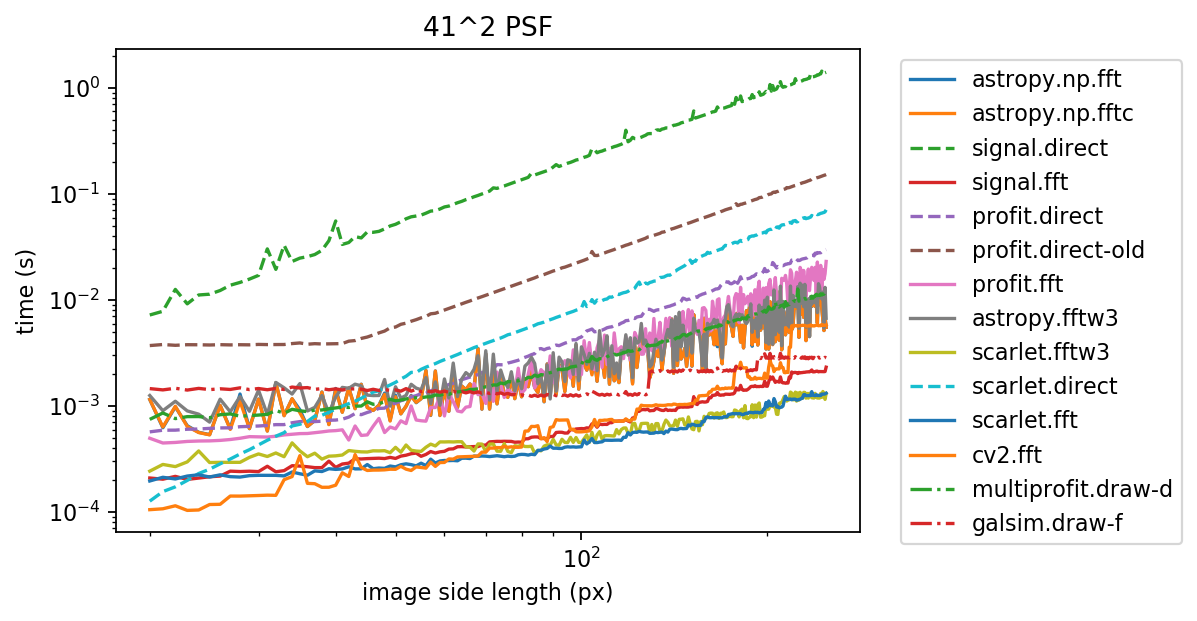

In [8]:
for size_psf, results_psf in results.items():
    plt.figure()
    for name, values in results_psf.items():
        n_values = len(values)
        size_img, time = np.zeros(n_values), np.zeros(n_values)
        for idx in range(n_values):
            value = values[idx]
            size_img[idx] = value[1]
            time[idx] = value[0]
        plt.plot(size_img, time, label=name, linestyle='-' if 'fft' in name else ('--' if 'direct' in name else '-.'))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('image side length (px)')
    plt.ylabel('time (s)')
    plt.title(f'{size_psf}^2 PSF')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")